In [ ]:
!pip install -q numpy scipy soundfile torch torchaudio speechbrain matplotlib ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.1/754.1 kB 35.8 MB/s eta 0:00:00


In [ ]:
import scipy.io as sio
import numpy as np
import soundfile as sf

# Load the .mat file
mat = sio.loadmat("/content/audio_smir_data3.mat")
X = mat["audio_smir"]   # shape (32, 80031)
fs_array = 16000
print("Loaded:", X.shape)


Loaded: (32, 80031)


In [ ]:
pip install numpy scipy soundfile pyroomacoustics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 50.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.4-cp312-cp312-linux_x86_64.whl size=47010705 sha256=c72b83da39aca7258fd489e77879f116c8f0e04f6fbb4868cce17b8f46d53fc4
  Stored in directory: /root/.cache/pip/wheels/71/2f/16/3cc6a78182189d4cde42c8f6658c1c8567cb4cc1146e61c9cb
Successfully built pyroomacoustics


Loaded matrix shape: (32, 80031) dtype: float64
Saved 32 per-mic wavs in output_from_mat
Running GCC-PHAT TDOA estimation and integer Delay-and-Sum...
TDOA (s) per mic: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Integer shifts (samples): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Saved beamformed (16 kHz): output_from_mat/beamformed_16k.wav duration(s): 5.0018125
Reference mic (center) waveform & spectrogram:


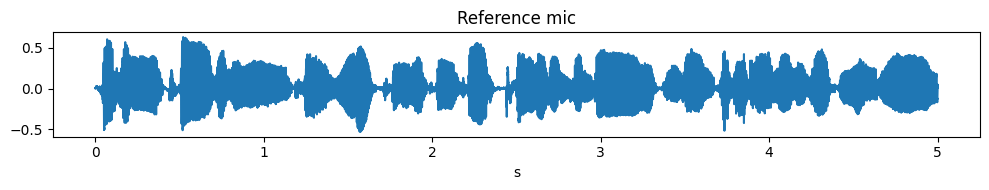

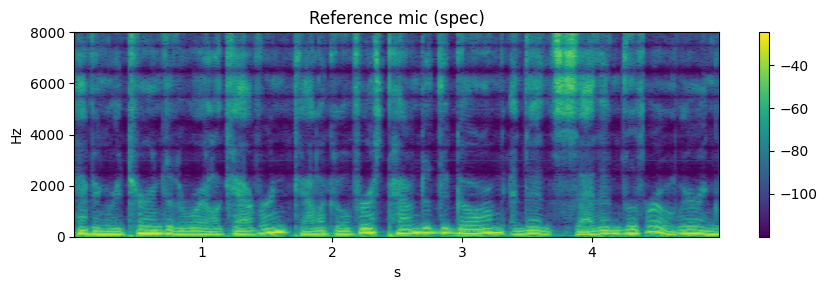

Beamformed waveform & spectrogram:


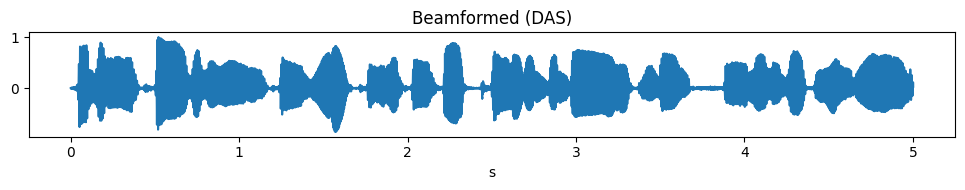

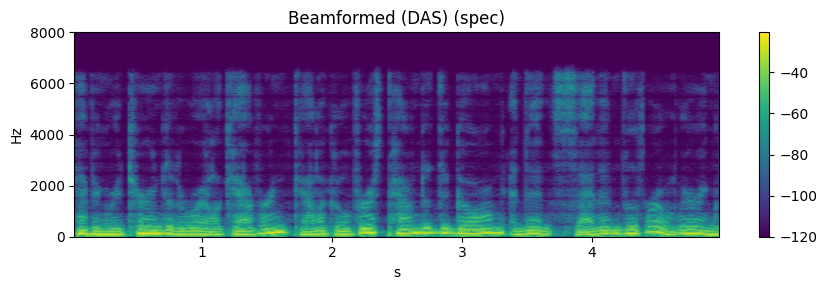

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/sepformer-whamr/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached


Saved beamformed (8 kHz) for SepFormer
Loading SepFormer (this may download weights if not cached)...


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/sepformer-whamr.
INFO:speechbrain.utils.fetching:Fetch masknet.ckpt: Using symlink found at '/content/pretrained_models/sepformer-whamr/masknet.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["masknet"] = /content/pretrained_models/sepformer-whamr/masknet.ckpt
INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Using symlink found at '/content/pretrained_models/sepformer-whamr/encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["encoder"] = /content/pretrained_models/sepformer-whamr/encoder.ckpt
INFO:speechbrain.utils.fetching:Fetch decoder.ckpt: Using symlink found at '/content/pretrained_models/sepformer-whamr/decoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["decoder"] = /content/pretrained_models/sepformer-whamr/decoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading 

Saved SepFormer outputs (postproc) in output_from_mat


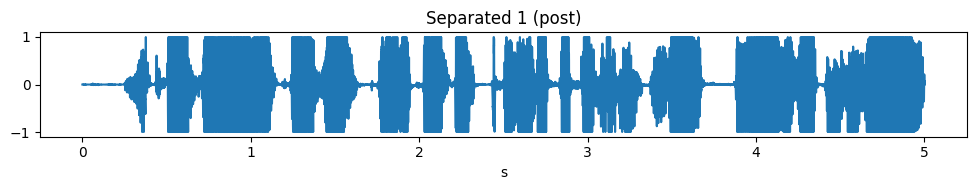

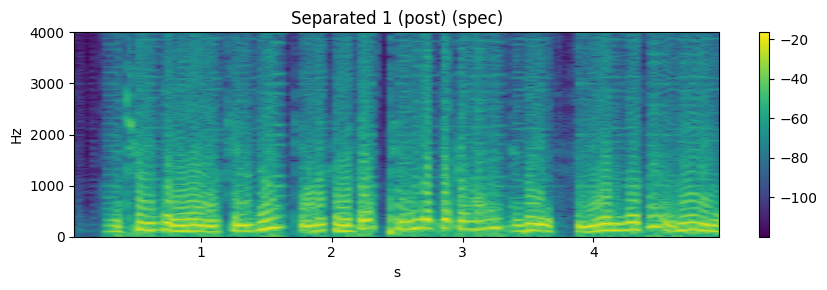

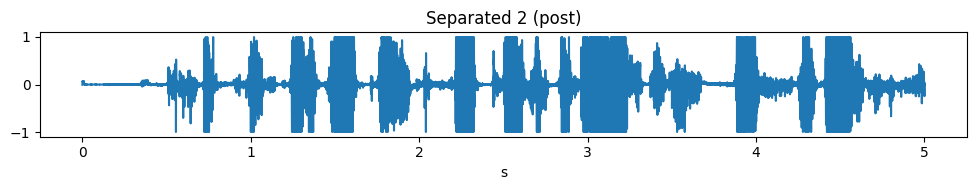

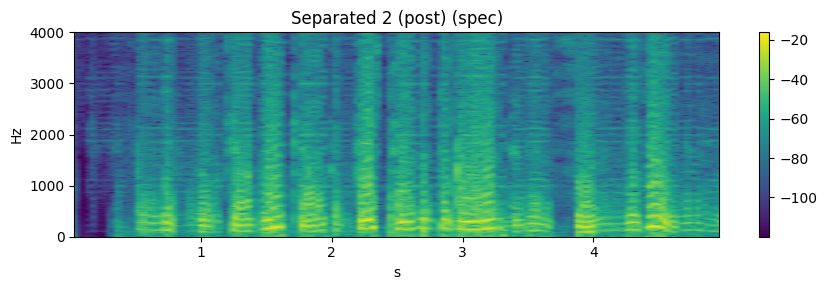

In [ ]:
# Full pipeline: load .mat -> beamform (DAS) -> postfilter -> SepFormer -> postproc -> visualize
# Paste into Colab / local Python (requires: numpy, scipy, soundfile, matplotlib, torch, torchaudio, speechbrain, whisper, jiwer (optional))

import numpy as np
import soundfile as sf
import scipy.io
import scipy.signal as sig
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os

# -------- optional heavy imports (set RUN_SEPF False to skip) ----------
RUN_SEPF = True   # set False to only do beamforming & visualization (fast)
RUN_ASR  = False  # set True if you want Whisper transcription (slow, requires model)
if RUN_SEPF:
    import torch, torchaudio
    from speechbrain.inference.separation import SepformerSeparation as Separator
if RUN_ASR:
    import whisper
    from jiwer import wer

# ----------------------- Helpers -----------------------
def load_mat_get_matrix(path, var_name=None):
    m = scipy.io.loadmat(path)
    # choose variable if provided, else choose largest 2D array variable
    if var_name is not None:
        return m[var_name]
    # pick candidate arrays with 2 dims and numeric
    candidates = {k:v for k,v in m.items() if isinstance(v, np.ndarray) and v.ndim==2 and v.size>0}
    if not candidates:
        raise ValueError("No 2D arrays found in .mat")
    # choose largest (most elements)
    key = max(candidates.keys(), key=lambda k: candidates[k].size)
    return candidates[key]

def normalize_per_channel(mat):
    mat = mat.astype(np.float32)
    for i in range(mat.shape[0]):
        maxv = np.max(np.abs(mat[i])) + 1e-12
        mat[i] = mat[i] / maxv
    return mat


def gcc_phat(sig1, sig2, fs, max_tau=None, interp=16):
    # returns estimated time delay (seconds) of sig1 relative to sig2 (sig1 leads => positive tau)
    n = sig1.shape[0] + sig2.shape[0]
    N = 1<< (int(np.ceil(np.log2(n))))
    # FFT
    S1 = np.fft.rfft(sig1, n=N)
    S2 = np.fft.rfft(sig2, n=N)
    R = S1 * np.conjugate(S2)
    denom = np.abs(R)
    denom[denom==0] = 1e-16
    R /= denom
    cc = np.fft.irfft(R, n=N)
    max_shift = int(N/2)
    if max_tau:
        max_shift = min(max_shift, int(np.ceil(max_tau*fs)))
    # shift
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))
    shift = np.argmax(np.abs(cc)) - max_shift
    tau = shift / float(fs)
    return tau

def delay_and_sum_integer_roll(signals, fs, ref_idx=0, max_tau=None):
    """
    signals: (M, T) numpy
    returns: beamformed (T,) numpy (trimmed to avoid wrap-around)
    """
    M, T = signals.shape
    ref = signals[ref_idx]
    delays = np.zeros(M)
    for m in range(M):
        if m == ref_idx:
            delays[m] = 0.0
            continue
        tau = gcc_phat(signals[m], ref, fs, max_tau=max_tau)
        delays[m] = tau
    # convert to integer shifts (samples)
    shifts = np.round(delays * fs).astype(int)
    # align: shift each channel by -shifts[m] (so ref stays in place)
    aligned = np.zeros_like(signals)
    for m in range(M):
        shift = -shifts[m]
        aligned[m] = np.roll(signals[m], shift)
    # avoid wrap-around artifacts: find region where most channels have valid data
    # compute valid region by trimming max absolute shift at start/end
    max_shift = np.max(np.abs(shifts))
    start = int(max_shift + 1)
    end = T - start
    bf = np.mean(aligned[:, start:end], axis=0)
    return bf, delays, shifts, start, end

def bandpass_filter(sig_in, fs, low=80, high=None, order=4):
    if high is None:
        high = fs/2 - 100
    sos = sig.butter(order, [low, high], btype='band', fs=fs, output='sos')
    return sig.sosfiltfilt(sos, sig_in)

def rms(x):
    return np.sqrt(np.mean(x**2) + 1e-12)

def match_rms(y, target_rms):
    return y * (target_rms / (rms(y) + 1e-12))

def sign_and_rms_fix(est1, est2):
    # align sign of est2 to est1 if anti-correlated
    L = min(len(est1), len(est2))
    e1 = est1[:L]; e2 = est2[:L]
    corr = np.corrcoef(e1, e2)[0,1]
    if corr < 0:
        e2 = -e2
    # RMS-match to average energy
    r = (rms(e1) + rms(e2)) / 2.0
    e1 = match_rms(e1, r)
    e2 = match_rms(e2, r)
    return e1, e2

# ----------------------- Main procedure -----------------------
def pipeline_from_mat(mat_path, fs=16000, ref_mic=None, save_folder="out", run_sepformer=RUN_SEPF, run_asr=RUN_ASR):
    os.makedirs(save_folder, exist_ok=True)
    # 1) load
    mat = load_mat_get_matrix(mat_path)
    print("Loaded matrix shape:", mat.shape, "dtype:", mat.dtype)
    M, T = mat.shape
    # 2) normalize
    mat = normalize_audio_matrix(mat)
    if ref_mic is None:
        ref_mic = M//2  # center mic
    # 3) optional: save all mics (useful)
    for i in range(M):
        sf.write(os.path.join(save_folder, f"mic_{i+1:02d}.wav"), mat[i], fs)
    print(f"Saved {M} per-mic wavs in {save_folder}")
    # 4) beamform (integer delay-and-sum using GCC-PHAT)
    print("Running GCC-PHAT TDOA estimation and integer Delay-and-Sum...")
    bf, delays, shifts, start, end = delay_and_sum_integer_roll(mat, fs, ref_idx=ref_mic, max_tau=0.02)
    print("TDOA (s) per mic:", np.round(delays,6))
    print("Integer shifts (samples):", shifts)
    # 5) postfilter / smooth
    bf_filtered = bandpass_filter(bf, fs, low=80, high=min(8000, fs//2 - 100), order=4)
    # small smoothing (optional) - lowpass
    bf_filtered = sig.decimate(bf_filtered, 1)  # no-op, placeholder if want decimate

    # normalize BF signal
    bf_filtered = bf_filtered / (np.max(np.abs(bf_filtered)) + 1e-12)

    # Save beamformed output (16 kHz)
    bf_path = os.path.join(save_folder, "beamformed_16k.wav")
    sf.write(bf_path, bf_filtered, fs, subtype='PCM_16')
    print("Saved beamformed (16 kHz):", bf_path, "duration(s):", len(bf_filtered)/fs)

    # 6) visualize beamformed vs reference mic (waveform + spectrogram)
    # plot short segments
    def plot_wave_and_spec(x, sr, title):
        t = np.linspace(0, len(x)/sr, len(x))
        plt.figure(figsize=(10,2)); plt.plot(t, x); plt.title(title); plt.xlabel("s"); plt.tight_layout(); plt.show()
        f, tt, Sxx = sig.spectrogram(x, sr, nperseg=512, noverlap=256)
        plt.figure(figsize=(9,3)); plt.pcolormesh(tt, f, 10*np.log10(Sxx+1e-12), shading='gouraud'); plt.title(title+" (spec)"); plt.ylabel("Hz"); plt.xlabel("s"); plt.colorbar(); plt.tight_layout(); plt.show()

    print("Reference mic (center) waveform & spectrogram:")
    plot_wave_and_spec(mat[ref_mic], fs, "Reference mic")
    print("Beamformed waveform & spectrogram:")
    plot_wave_and_spec(bf_filtered, fs, "Beamformed (DAS)")

    display(Audio(mat[ref_mic], rate=fs))
    display(Audio(bf_filtered, rate=fs))

    # 7) Resample to SepFormer sampling rate (8 kHz) and run separation
    if run_sepformer:
        target_sr = 8000
        bf_8k = torchaudio.functional.resample(torch.tensor(bf_filtered).float(), orig_freq=fs, new_freq=target_sr).numpy()
        bf_8k = bf_8k / (np.max(np.abs(bf_8k)) + 1e-12)
        sf.write(os.path.join(save_folder, "beamformed_8k.wav"), bf_8k, target_sr, subtype='PCM_16')
        print("Saved beamformed (8 kHz) for SepFormer")

        print("Loading SepFormer (this may download weights if not cached)...")
        sep = Separator.from_hparams(source="speechbrain/sepformer-whamr", savedir="pretrained_models/sepformer-whamr",
                                     run_opts={"device":"cuda" if torch.cuda.is_available() else "cpu"})
        with torch.no_grad():
            wav = torch.tensor(bf_8k).float().unsqueeze(0)
            est = sep.separate_batch(wav.to("cuda" if torch.cuda.is_available() else "cpu"))
        s1 = est[0,:,0].cpu().numpy()
        s2 = est[0,:,1].cpu().numpy()
        # postproc: sign + rms
        s1p, s2p = sign_and_rms_fix(s1, s2)
        # limit amplitude to avoid roughness
        s1p = np.clip(s1p, -0.99, 0.99)
        s2p = np.clip(s2p, -0.99, 0.99)
        sf.write(os.path.join(save_folder, "est_source1_raw.wav"), s1p, target_sr, subtype='PCM_16')
        sf.write(os.path.join(save_folder, "est_source2_raw.wav"), s2p, target_sr, subtype='PCM_16')
        print("Saved SepFormer outputs (postproc) in", save_folder)

        # visualize sep outputs
        plot_wave_and_spec(s1p, target_sr, "Separated 1 (post)")
        plot_wave_and_spec(s2p, target_sr, "Separated 2 (post)")
        display(Audio(s1p, rate=target_sr))
        display(Audio(s2p, rate=target_sr))
    else:
        print("SepFormer skipped (run_sepformer=False). You can run it later on beamformed_8k.wav")

    # 8) optional ASR & WER
    if run_asr and RUN_ASR:
        model = whisper.load_model("small")
        out1 = model.transcribe(os.path.join(save_folder, "est_source1_raw.wav"))["text"]
        out2 = model.transcribe(os.path.join(save_folder, "est_source2_raw.wav"))["text"]
        print("ASR Source1:", out1)
        print("ASR Source2:", out2)
    return

# ----------------------- Run pipeline -----------------------
MAT_PATH = "/content/audio_smir_data3.mat"   # change if needed
pipeline_from_mat(MAT_PATH, fs=16000, ref_mic=None, save_folder="output_from_mat", run_sepformer=RUN_SEPF, run_asr=False)


(80031,) -0.5096435546875 0.604095458984375


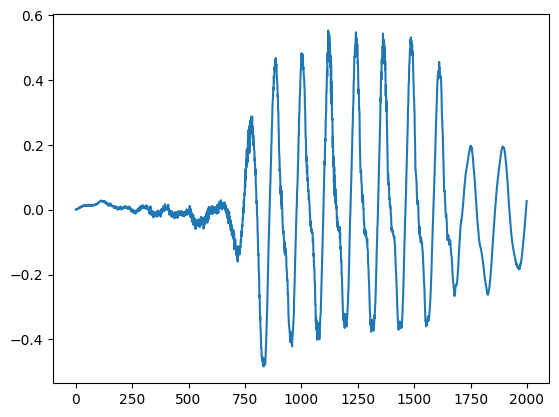

In [ ]:
import soundfile as sf
import matplotlib.pyplot as plt
x, sr = sf.read("output_from_mat/mic_01.wav")
print(x.shape, x.min(), x.max())
plt.plot(x[:2000]); plt.show()


In [ ]:
from pyroomacoustics.beamforming import steering_vector


ImportError: cannot import name 'steering_vector' from 'pyroomacoustics.beamforming' (/usr/local/lib/python3.12/dist-packages/pyroomacoustics/beamforming.py)

In [ ]:
import numpy as np
import pyroomacoustics as pra
import soundfile as sf

# --- Setup ---
M, T = X.shape
radius = 0.042
fs = FS_ARRAY

# Circular mic array
mic_positions = pra.circular_2D_array(center=[0, 0], M=M, radius=radius, phi0=0)
mic_positions = np.vstack((mic_positions, np.zeros((1, M))))  # make it 3D

# Beamformer object
L = 512
bf = pra.Beamformer(mic_positions, fs=fs, N=L)
bf.signals = X

# --- Steering vector for look direction (0° azimuth, horizontal plane) ---
az = 0 * np.pi / 180    # look azimuth (front)
el = 90 * np.pi / 180   # elevation (horizontal plane)
look_dir = [np.cos(az) * np.sin(el), np.sin(az) * np.sin(el), np.cos(el)]

# Compute steering vector
d = pra.steering_vector(mic_positions, look_dir, bf.frequencies, fs)

# Set Delay-and-Sum weights (normalize)
bf.weights = d / M

# --- Apply Beamforming ---
y_ds = bf.process()
print("✅ Beamformed signal shape:", y_ds.shape)

# Save output
sf.write("beamformed.wav", y_ds, fs)
print("💾 Saved: beamformed.wav")


AttributeError: module 'pyroomacoustics' has no attribute 'steering_vector'

In [ ]:
import torch, torchaudio
from speechbrain.inference.separation import SepformerSeparation as Separator

def resample(sig, orig, new):
    t = torch.tensor(sig).float()
    return torchaudio.functional.resample(t, orig_freq=orig, new_freq=new).numpy()

beam8k = resample(y_ds, fs_array, 8000)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sep = Separator.from_hparams(
    source="speechbrain/sepformer-whamr",
    savedir="pretrained_models/sepformer-whamr",
    run_opts={"device": device}
)

wav = torch.tensor(beam8k).float().unsqueeze(0)   # [B,T]
with torch.no_grad():
    out = sep.separate_batch(wav.to(device))      # [B,T,2]

s1 = out[0,:,0].cpu().numpy()
s2 = out[0,:,1].cpu().numpy()

# Normalize each
def normalize(sig):
    return sig / (np.max(np.abs(sig)) + 1e-9)

s1 = normalize(s1)
s2 = normalize(s2)

sf.write("sep_source1.wav", s1, 8000, subtype="PCM_16")
sf.write("sep_source2.wav", s2, 8000, subtype="PCM_16")
print("✅ Separation complete → sep_source1.wav / sep_source2.wav")


In [ ]:
print("Durations: mix=%.2fs, beamformed=%.2fs, s1=%.2fs, s2=%.2fs" %
      (len(X[0])/fs_array, len(y_ds)/fs_array, len(s1)/8000, len(s2)/8000))


In [ ]:
# Try WHAMR (noisy+reverb) first; if your data is quite clean, try wsj02mix.
MODEL = "speechbrain/sepformer-whamr"  # or "speechbrain/sepformer-wsj02mix"

s1, s2, sr_sep = run_sepformer(mono_in, sr_in=FS_ARRAY, target_sr=TARGET_SR, model=MODEL)

# Post-process outputs for listenability (RMS match + limiter, optional sign alignment)
def post_process_pair(a, b, fs):
    # Band-limit to telephony band to reduce harshness at 8k
    a = bandpass(a, fs, 80, 3600); b = bandpass(b, fs, 80, 3600)
    # same RMS to compare fairly
    a = rms_norm(a, -20); b = rms_norm(b, -20)
    # avoid clipping
    a = peak_norm(a, -1); b = peak_norm(b, -1)
    a = soft_limiter(a, 0.97, 0.15); b = soft_limiter(b, 0.97, 0.15)
    # flip sign of b if strongly anticorrelated with a (for perceptual comparison only)
    if np.corrcoef(a[:len(b)], b[:len(a)])[0,1] < -0.2:
        b = -b
    return a.astype(np.float32), b.astype(np.float32)

s1p, s2p = post_process_pair(s1, s2, sr_sep)

sf.write("est_source1.wav", s1p, sr_sep, subtype="PCM_16")
sf.write("est_source2.wav", s2p, sr_sep, subtype="PCM_16")
print(f"Saved → est_source1.wav / est_source2.wav @ {sr_sep} Hz")

display(Audio("est_source1.wav"))
display(Audio("est_source2.wav"))


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/sepformer-whamr/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/sepformer-whamr.
INFO:speechbrain.utils.fetching:Fetch masknet.ckpt: Using symlink found at '/content/pretrained_models/sepformer-whamr/masknet.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["masknet"] = /content/pretrained_models/sepformer-whamr/masknet.ckpt
INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Using symlink found at '/content/pretrained_models/sepformer-whamr/encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["encoder"] = /content/pretrained_models/sepformer-whamr/encoder.ckpt
INFO:speechbrain.utils.fetching:Fetch decoder.ckpt: Using sy

Saved → est_source1.wav / est_source2.wav @ 8000 Hz


In [ ]:
matrix = mat["audio_smir"]   # shape (32, 80001)
print(matrix.shape)

(32, 80031)


In [ ]:
import soundfile as sf

def to_float(x):
    return x.astype(np.float32) / (np.max(np.abs(x)) + 1e-9)

matrix = to_float(matrix)

center_idx = matrix.shape[0] // 2
center_mic = matrix[center_idx]

sf.write("mixed.wav", center_mic, 16000, subtype="PCM_16")
print("✅ Saved mixed.wav:", center_mic.shape, "samples")


✅ Saved mixed.wav: (80031,) samples


In [ ]:
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.1/754.1 kB 31.8 MB/s eta 0:00:00


In [ ]:
import torch
import torchaudio
from speechbrain.inference.separation import SepformerSeparation as Separator

TARGET_SR = 8000
ARRAY_SR  = 16000

def resample_1d(x, orig, new):
    t = torch.tensor(x).float()
    if orig != new:
        t = torchaudio.functional.resample(t, orig_freq=orig, new_freq=new)
    return t.numpy()

def run_sepformer(mono, sr_in=16000, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    x8 = resample_1d(mono, sr_in, TARGET_SR)
    wav = torch.tensor(x8).float().unsqueeze(0)  # [B,T]
    sep = Separator.from_hparams(
        source="speechbrain/sepformer-whamr",
        savedir="pretrained_models/sepformer-whamr",
        run_opts={"device": device}
    )
    with torch.no_grad():
        out = sep.separate_batch(wav.to(device))  # [B,T,2]
    s1 = out[0, :, 0].cpu().numpy()
    s2 = out[0, :, 1].cpu().numpy()
    return s1, s2, TARGET_SR

s1, s2, sr_sep = run_sepformer(center_mic, sr_in=ARRAY_SR)
sf.write("est_source1.wav", s1, sr_sep)
sf.write("est_source2.wav", s2, sr_sep)
print("✅ Separation complete → est_source1.wav / est_source2.wav")


/usr/local/lib/python3.12/dist-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoi

hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--sepformer-whamr/snapshots/9950fd8055b38679d2af5bef2366b5dba600ec66/hyperparams.yaml' -> '/content/pretrained_models/sepformer-whamr/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached
/usr/local/lib/python3.12/dist-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.parameter_transfer:Co

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--sepformer-whamr/snapshots/9950fd8055b38679d2af5bef2366b5dba600ec66/masknet.ckpt' -> '/content/pretrained_models/sepformer-whamr/masknet.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["masknet"] = /content/pretrained_models/sepformer-whamr/masknet.ckpt
INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached


encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--sepformer-whamr/snapshots/9950fd8055b38679d2af5bef2366b5dba600ec66/encoder.ckpt' -> '/content/pretrained_models/sepformer-whamr/encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["encoder"] = /content/pretrained_models/sepformer-whamr/encoder.ckpt
INFO:speechbrain.utils.fetching:Fetch decoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached


decoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--sepformer-whamr/snapshots/9950fd8055b38679d2af5bef2366b5dba600ec66/decoder.ckpt' -> '/content/pretrained_models/sepformer-whamr/decoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["decoder"] = /content/pretrained_models/sepformer-whamr/decoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: masknet, encoder, decoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): masknet -> /content/pretrained_models/sepformer-whamr/masknet.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): encoder -> /content/pretrained_models/sepformer-whamr/encoder.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): decoder -> /content/pretrained_models/sepformer-whamr/decoder.ckpt


✅ Separation complete → est_source1.wav / est_source2.wav


In [ ]:
import numpy as np

# Assuming you already have arrays: mix, s1, s2 and sample rates sr_mix, sr1, sr2
# Make sure same length for fair comparison:
L = min(len(s1), len(s2))
s1_ = s1[:L]
s2_ = s2[:L]

# Mean absolute difference (you computed already)
mad = np.mean(np.abs(s1_ - s2_))
print("Mean abs diff:", mad)

# Pearson correlation (1.0 = identical shape up to scale; -1.0 = inverted)
corr = np.corrcoef(s1_, s2_)[0, 1]
print("Correlation s1 vs s2:", corr)

# RMS energy
rms1 = np.sqrt(np.mean(s1_**2))
rms2 = np.sqrt(np.mean(s2_**2))
print(f"RMS: s1={rms1:.4f}, s2={rms2:.4f}")


Mean abs diff: 0.5563521
Correlation s1 vs s2: -0.18446456509350084
RMS: s1=0.5039, s2=0.5718


In [ ]:
import numpy as np
diff = np.mean(np.abs(s1 - s2))
print("Mean absolute difference between outputs:", diff)


Mean absolute difference between outputs: 0.5563521


In [ ]:
!pip install -q git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install -y ffmpeg

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,940 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,188 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http

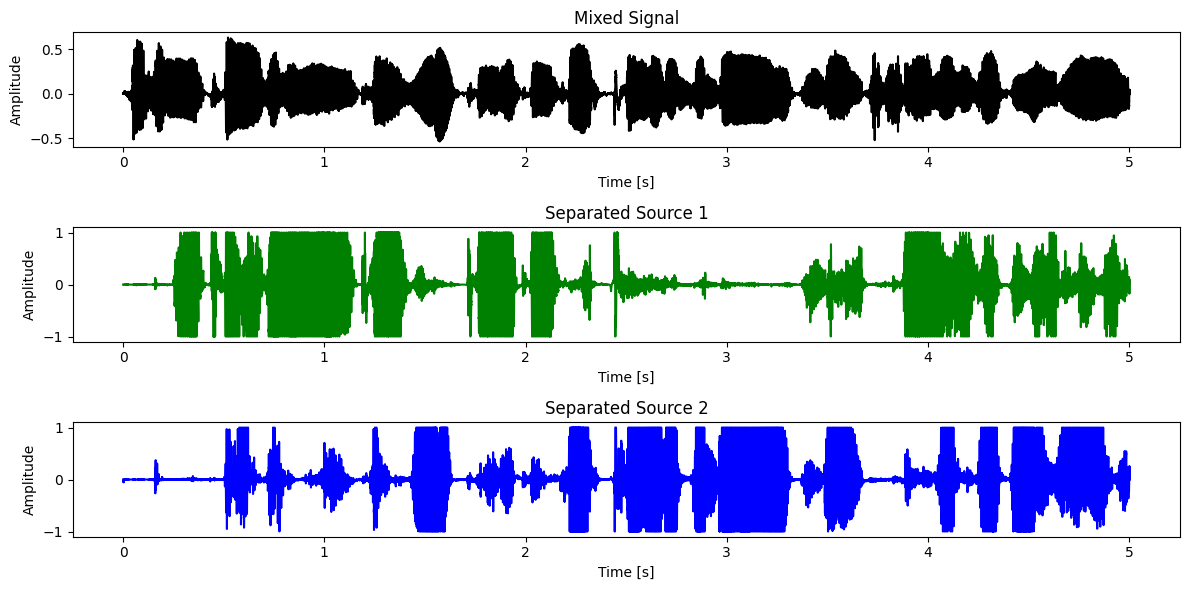

🔊 Mixed Signal


🔊 Separated Source 1


🔊 Separated Source 2


In [ ]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ----------------- Load signals -----------------
mix, sr_mix = sf.read("mixed.wav")              # Mixed signal
s1, sr1 = sf.read("est_source1.wav")            # Separated source 1
s2, sr2 = sf.read("est_source2.wav")            # Separated source 2

# ----------------- Create time axes -----------------
t_mix = np.linspace(0, len(mix)/sr_mix, len(mix))
t1 = np.linspace(0, len(s1)/sr1, len(s1))
t2 = np.linspace(0, len(s2)/sr2, len(s2))

# ----------------- Plot signals -----------------
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
plt.plot(t_mix, mix, color="black")
plt.title("Mixed Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(3,1,2)
plt.plot(t1, s1, color="green")
plt.title("Separated Source 1")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(3,1,3)
plt.plot(t2, s2, color="blue")
plt.title("Separated Source 2")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# ----------------- Play audio -----------------
print("🔊 Mixed Signal")
display(Audio(mix, rate=sr_mix))

print("🔊 Separated Source 1")
display(Audio(s1, rate=sr1))

print("🔊 Separated Source 2")
display(Audio(s2, rate=sr2))


In [ ]:
import whisper
model = whisper.load_model("base")   # or "small"/"medium"/"large"

result1 = model.transcribe("est_source1.wav")
result2 = model.transcribe("est_source2.wav")

print("Source 1 Transcript:", result1["text"])
print("Source 2 Transcript:", result2["text"])


100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 126MiB/s]
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Source 1 Transcript:  Return to the Royal Castle, Calacruzers, Penetrate, and then it's done in different ways.
Source 2 Transcript:  Except that we wereолет't right but that the first pounded the ground didn't slide even before there we go


In [ ]:
!pip install -q jiwer torchaudio soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torchaudio
import soundfile as sf
from speechbrain.inference.separation import SepformerSeparation as separator

# ------------------- load dataset -------------------
mixed_signals = np.load("mixed_matrix.npy")   # shape (M, T)
print("Loaded shape:", mixed_signals.shape)

# normalize
mixed_signals = mixed_signals / np.max(np.abs(mixed_signals))

# ------------------- pick mic -------------------
center_mic = mixed_signals[0]     # choose first mic (or middle one)
center_mic = torch.tensor(center_mic).float()

# ------------------- resample to 8k -------------------
orig_sr = 16000
target_sr = 8000
center_mic_8k = torchaudio.functional.resample(
    center_mic, orig_freq=orig_sr, new_freq=target_sr
)

# reshape for model: [batch, time]
center_mic_8k = center_mic_8k.unsqueeze(0)

# ------------------- load SepFormer -------------------
model = separator.from_hparams(
    source="speechbrain/sepformer-whamr",
    savedir="pretrained_models/sepformer-whamr",
    run_opts={"device": "cuda" if torch.cuda.is_available() else "cpu"}
)

# ------------------- separate -------------------
with torch.no_grad():
    est_sources = model.separate_batch(center_mic_8k)

# extract results
s1 = est_sources[0, :, 0].cpu().numpy()
s2 = est_sources[0, :, 1].cpu().numpy()

# ------------------- save -------------------
sf.write("separated_source1.wav", s1, target_sr, subtype="PCM_16")
sf.write("separated_source2.wav", s2, target_sr, subtype="PCM_16")

print("✅ Separation done → separated_source1.wav / separated_source2.wav @ 8 kHz")


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached


Loaded shape: (32, 10031)


hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--sepformer-whamr/snapshots/9950fd8055b38679d2af5bef2366b5dba600ec66/hyperparams.yaml' -> '/content/pretrained_models/sepformer-whamr/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/sepformer-whamr.
INFO:speechbrain.utils.fetching:Fetch masknet.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached


masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--sepformer-whamr/snapshots/9950fd8055b38679d2af5bef2366b5dba600ec66/masknet.ckpt' -> '/content/pretrained_models/sepformer-whamr/masknet.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["masknet"] = /content/pretrained_models/sepformer-whamr/masknet.ckpt
INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached


encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--sepformer-whamr/snapshots/9950fd8055b38679d2af5bef2366b5dba600ec66/encoder.ckpt' -> '/content/pretrained_models/sepformer-whamr/encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["encoder"] = /content/pretrained_models/sepformer-whamr/encoder.ckpt
INFO:speechbrain.utils.fetching:Fetch decoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-whamr' if not cached


decoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--sepformer-whamr/snapshots/9950fd8055b38679d2af5bef2366b5dba600ec66/decoder.ckpt' -> '/content/pretrained_models/sepformer-whamr/decoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["decoder"] = /content/pretrained_models/sepformer-whamr/decoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: masknet, encoder, decoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): masknet -> /content/pretrained_models/sepformer-whamr/masknet.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): encoder -> /content/pretrained_models/sepformer-whamr/encoder.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): decoder -> /content/pretrained_models/sepformer-whamr/decoder.ckpt


✅ Separation done → separated_source1.wav / separated_source2.wav @ 8 kHz


In [ ]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from ipywidgets import VBox, Output
from IPython.display import display, Audio
from scipy.signal import spectrogram

# ------------------- Load signals -------------------
mix = np.load("mixed_matrix.npy")   # shape: (M, T)
sr_mix = 16000                      # your simulation fs

# take reference mic (first channel for visualization)
mix_ref = mix[0]

# separated signals (already saved at 8kHz)
src1, sr1 = sf.read("est_source1.wav")
src2, sr2 = sf.read("est_source2.wav")

# ------------------- Time axes -------------------
t_mix = np.linspace(0, len(mix_ref)/sr_mix, len(mix_ref))
t1 = np.linspace(0, len(src1)/sr1, len(src1))
t2 = np.linspace(0, len(src2)/sr2, len(src2))

# ------------------- Helper: Plot Spectrogram -------------------
def plot_spectrogram(signal, sr, title):
    f, t, Sxx = spectrogram(signal, fs=sr, nperseg=256, noverlap=128)
    plt.pcolormesh(t, f, 10*np.log10(Sxx+1e-10), shading='gouraud')
    plt.title(title + " (Spectrogram)")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label="Power [dB]")
    plt.tight_layout()

# ------------------- Outputs -------------------
out_mix = Output()
out_s1 = Output()
out_s2 = Output()

with out_mix:
    print("🎵 Mixed Signal (Mic 1)")
    plt.figure(figsize=(10, 2))
    plt.plot(t_mix, mix_ref, color='black')
    plt.title("Mixed Signal (Mic 1) - Waveform")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plot_spectrogram(mix_ref, sr_mix, "Mixed Signal (Mic 1)")
    plt.show()
    display(Audio(mix_ref, rate=sr_mix))

with out_s1:
    print("🎵 Separated Source 1")
    plt.figure(figsize=(10, 2))
    plt.plot(t1, src1, color='green')
    plt.title("Separated Source 1 - Waveform")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plot_spectrogram(src1, sr1, "Separated Source 1")
    plt.show()
    display(Audio(src1, rate=sr1))

with out_s2:
    print("🎵 Separated Source 2")
    plt.figure(figsize=(10, 2))
    plt.plot(t2, src2, color='blue')
    plt.title("Separated Source 2 - Waveform")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plot_spectrogram(src2, sr2, "Separated Source 2")
    plt.show()
    display(Audio(src2, rate=sr2))

# ------------------- Display -------------------
display(VBox([out_mix, out_s1, out_s2]))
